In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import shapely.geometry as sgeom
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

In [2]:
nc = xr.load_dataset("/glm/G05GT1H/GLM_2020_01_hourly_05x05.nc")
glons = nc['lon'].data
glats = nc['lat'].data
gtimes = nc['time'].data
gvars = nc['var'].data

In [3]:
gdf = gpd.read_file("/home/adriano/CAP-395/data/GEO/Vector/SouthAmericaPolygon/South_America.shp")
country_geom = gdf[gdf['COUNTRY'] == 'Brazil'].iloc[0, -1]

clons, clats, lons_idx, lats_idx = [], [], [], []
out_lon, out_lat = [], []
for i, lat in enumerate(glats):
    for j, lon in enumerate(glons):
        if country_geom.contains(sgeom.Point(lon, lat)):
            clats.append(lat)
            clons.append(lon)
            lats_idx.append(i)
            lons_idx.append(j)
        else:
            out_lat.append(i)
            out_lon.append(j)
            
clons = np.array(clons)
clats = np.array(clats)

lons_idx = np.array(lons_idx)
lats_idx = np.array(lats_idx)

mlon, mlat = np.meshgrid(glons[lons_idx.min(): lons_idx.max()], 
                             glats[lats_idx.min(): lats_idx.max()])

In [4]:
lon_min, lon_max, lat_min, lat_max = clons.min(), clons.max(), clats.min(), clats.max()
res=0.5

res /= 2.
grid = gpd.GeoDataFrame()
for row in np.arange(lat_min, lat_max, res*2.):
    for col in np.arange(lon_min, lon_max, res*2.):
        poly = sgeom.Polygon(((col-res, row-res), (col+res, row-res), 
                              (col+res, row+res), (col-res, row+res), 
                              (col-res, row-res)))
        temp = gpd.GeoDataFrame({'geom': [poly]})
        grid = grid.append(temp)
grid = grid.reset_index()   
grid.head()

,index,geom
0,0,"POLYGON ((-73.75 -33.75, -73.25 -33.75, -73.25..."
1,0,"POLYGON ((-73.25 -33.75, -72.75 -33.75, -72.75..."
2,0,"POLYGON ((-72.75 -33.75, -72.25 -33.75, -72.25..."
3,0,"POLYGON ((-72.25 -33.75, -71.75 -33.75, -71.75..."
4,0,"POLYGON ((-71.75 -33.75, -71.25 -33.75, -71.25..."


In [5]:
matlc = np.load("/home/adriano/sthunder/land_cover.npy")

In [6]:
path = "/glm/G05GT1H/"
files = sorted([os.path.join(path, file) for file in os.listdir(path)])

mat = np.zeros((glats.shape[0], glons.shape[0]))
for i, file in enumerate(files):       
    gvars = xr.load_dataset(file)['var'].data
    
    for lat_idx, lon_idx in zip(lats_idx, lons_idx):
        mat[lat_idx][lon_idx] += gvars[:, lat_idx, lon_idx].sum()

mlon, mlat = np.meshgrid(glons[lons_idx.min(): lons_idx.max()], glats[lats_idx.min(): lats_idx.max()])
mat[out_lat, out_lon] = np.nan
    
maxv = 0
for ii in range(gvars.shape[1]):
    for jj in range(gvars.shape[2]):
        maxv = mat[ii, jj].sum() if mat[ii, jj].sum() > maxv else maxv
print(file, maxv)

/glm/G05GT1H/GLM_2020_12_hourly_05x05.nc 93088.0


In [7]:
# VEG_PALLETE = {
#     'Forest': '#129912', # rgb(18, 153, 18)
#     'Agriculture': '#ffffb2', # rgb(255, 255, 178)
#     'Non-forest natural formation': '#bbfcac', # rgb(187, 252, 172)
#     'Water': '#0000ff', # rgb(0, 0, 255)
#     'Unvegetated area': '#ea9999', # rgb(234, 153, 153)
#     'Null': '#d5d5e5' # rgb(213, 213, 229)
# }

VEG_PALLETE = {
    'Floresta': '#129912', # rgb(18, 153, 18)
    'Agropecuário': '#ffffb2', # rgb(255, 255, 178)
    'Formação natural': '#bbfcac', # rgb(187, 252, 172)
    'Água': '#0000ff', # rgb(0, 0, 255)
    'Área não vegetada': '#ea9999', # rgb(234, 153, 153)
    'Nulo': '#d5d5e5' # rgb(213, 213, 229)
}

PXL_BY_CLASS = [np.where(matlc == i)[0].shape[0] for i in range(1, 7)]

/home/adriano/sthunder/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


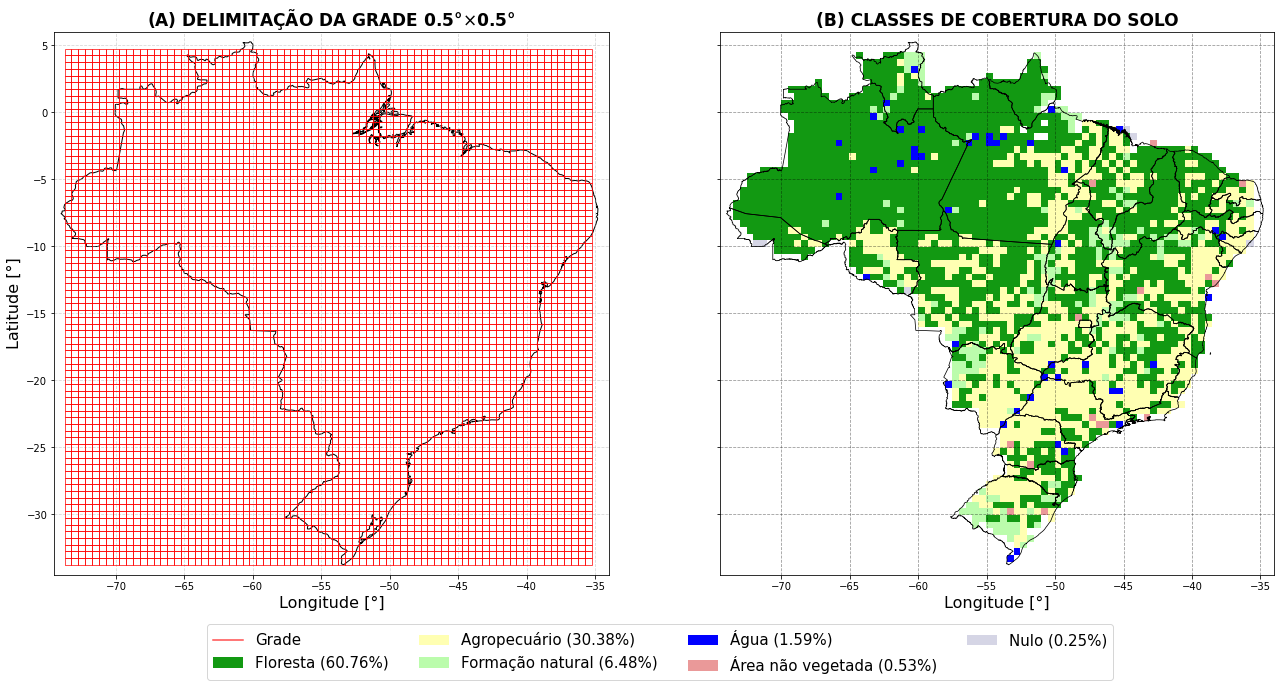

In [9]:
dpi = 100
width = np.round(1366 * 160 / 100)
height = 768*1.3
pad = 1


fig, ax = plt.subplots(1, 2, figsize=(width/dpi, height/dpi), 
                       sharex=True, sharey=True, facecolor='w')

# ax[0].set_title(r"(A) GRID DELIMITATION IN 0.5°$\times$0.5°", 
#                 fontdict={'size': 17, 'weight': 'bold'})
ax[0].set_title(r"(A) DELIMITAÇÃO DA GRADE 0.5°$\times$0.5°", 
                fontdict={'size': 17, 'weight': 'bold'})
for i, g in grid['geom'].iteritems():
    patch = PolygonPatch(g, fc='none', ec='r', alpha=0.7, zorder=2)
    ax[0].add_patch(patch)
    
patch = PolygonPatch(country_geom, fc='none', ec='k', zorder=1.5)
ax[0].add_patch(patch)

ax[0].set_xlim(clons.min()-pad, clons.max()+pad)
ax[0].set_ylim(clats.min()-pad, clats.max()+pad)

ax[0].grid(ls='--', alpha=0.5)
ax[0].set_xlabel("Longitude [°]", fontdict={'size': 16})
ax[0].set_ylabel("Latitude [°]", fontdict={'size': 16})



colors = ['#ffffff', *VEG_PALLETE.values()]
cmap = mpl.colors.ListedColormap(colors)
norm= mpl.colors.Normalize(vmin=0,vmax=6)

img = ax[1].pcolor(mlon, mlat, matlc.T[lats_idx.min():lats_idx.max(), 
                                        lons_idx.min(): lons_idx.max()],
                   cmap=cmap)    
states = gpd.read_file("/home/adriano/CAP-395/data/GEO/Vector/BrazilStatesPolygon/C02_unidades_da_federacao_2010Polygon.shp")
sbbox = states.total_bounds
pad = 1.
for i, row in states.iterrows():
    path = PolygonPatch(row['geometry'], ec='k', fc='none', lw=0.75)
    ax[1].add_patch(path)
ax[1].set_title(r"(B) CLASSES DE COBERTURA DO SOLO", 
                fontdict={'size': 17, 'weight': 'bold'})
ax[1].grid(ls='--', color='k', alpha=0.4)

ax[1].set_xlabel("Longitude [°]", fontdict={'size': 16})

ax[1].set_xlim(clons.min()-pad, clons.max()+pad)
ax[1].set_ylim(clats.min()-pad, clats.max()+pad)

cax = fig.add_axes([0.12, -0.02, 0.78, 0.075])

total = sum(PXL_BY_CLASS)
for i, (k, v) in enumerate(VEG_PALLETE.items()):
    perc = (PXL_BY_CLASS[i]/total)*100
    cax.bar([0], [0], color=[v], label=f"{k} ({perc:.2f}%)")
cax.plot([], label="Grade", color='red', alpha=0.7)
cax.legend(loc='center', ncol=4, fontsize=15)
cax.axis('off')

plt.savefig(f"../images_papers/maps_grid_and_landcover_pt.png", dpi=dpi,
                transparent=False, bbox_inches='tight', pad_inches=0.1)
# plt.savefig(f"../images_papers/maps_grid_and_landcover.pdf", dpi=dpi,
#                 transparent=False, bbox_inches='tight', pad_inches=0.1)

/home/adriano/sthunder/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/adriano/sthunder/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


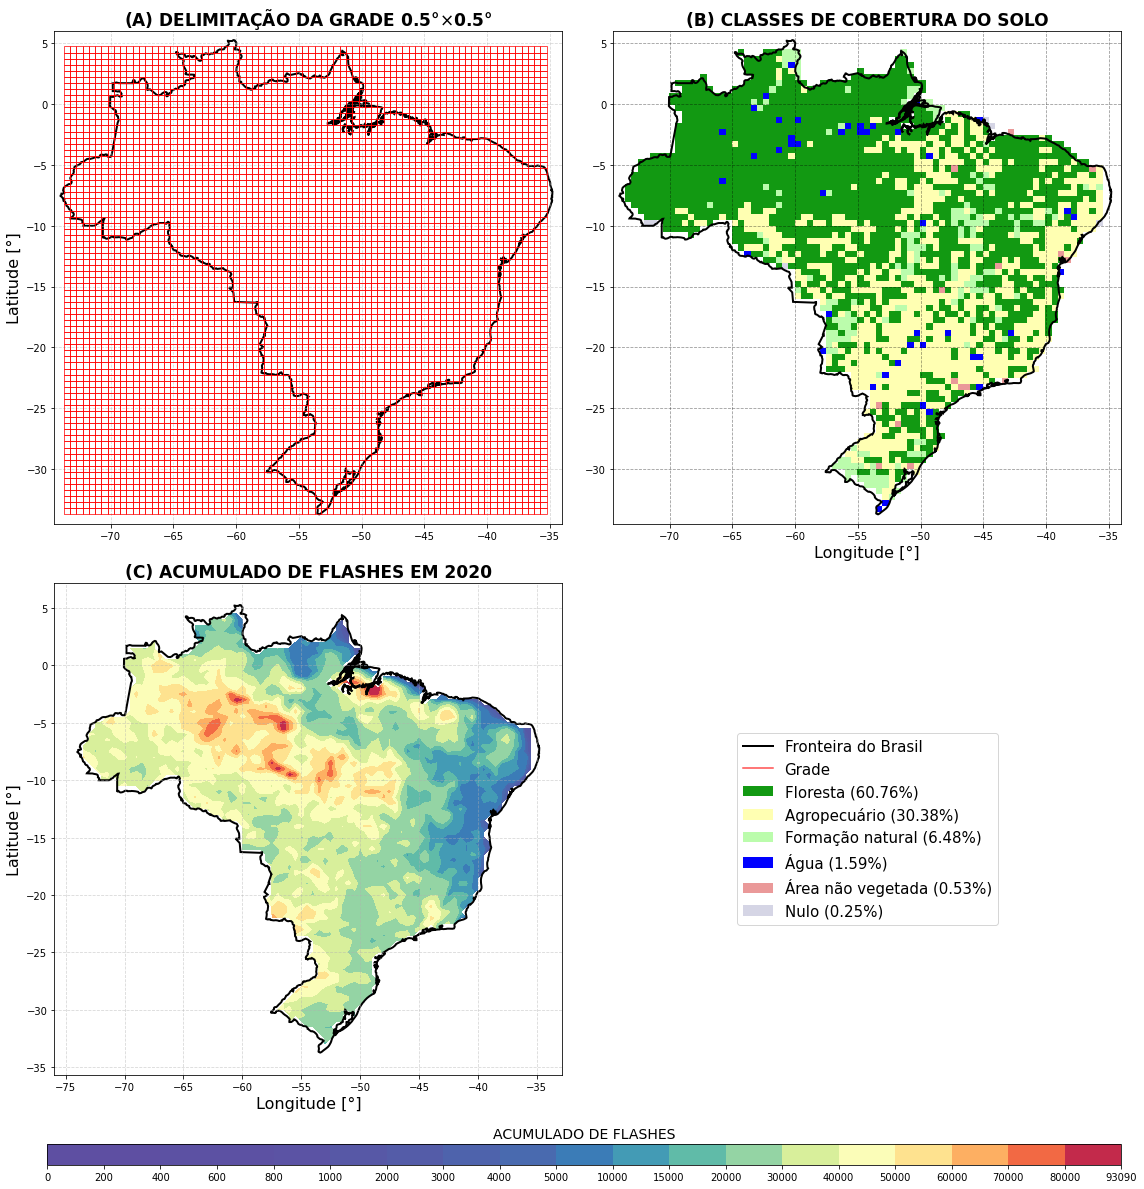

In [10]:
dpi = 100
width = np.round(1366 * 140 / 100)
height = 768*2.5


fig, ax = plt.subplots(2, 2, figsize=(width/dpi, height/dpi), 
                       sharex=False, sharey=False, facecolor='w')

ax[0][0].set_title(r"(A) DELIMITAÇÃO DA GRADE 0.5°$\times$0.5°", 
                fontdict={'size': 17, 'weight': 'bold'})
for i, g in grid['geom'].iteritems():
    patch = PolygonPatch(g, fc='none', ec='r', alpha=0.7, zorder=2)
    ax[0][0].add_patch(patch)
    
patch = PolygonPatch(country_geom, ec='k', fc='none', lw=2)
ax[0][0].add_patch(patch)

ax[0][0].set_xlim(clons.min()-pad, clons.max()+pad)
ax[0][0].set_ylim(clats.min()-pad, clats.max()+pad)

ax[0][0].grid(ls='--', alpha=0.5)
# ax[0][0].set_xlabel("Longitude [°]", fontdict={'size': 16})
ax[0][0].set_ylabel("Latitude [°]", fontdict={'size': 16})



colors = ['#ffffff', *VEG_PALLETE.values()]
cmap = mpl.colors.ListedColormap(colors)
norm= mpl.colors.Normalize(vmin=0,vmax=6)

img = ax[0][1].pcolor(mlon, mlat, matlc.T[lats_idx.min():lats_idx.max(), 
                                        lons_idx.min(): lons_idx.max()],
                   cmap=cmap)    
path = PolygonPatch(country_geom, ec='k', fc='none', lw=2)
ax[0][1].add_patch(path)
ax[0][1].set_title(r"(B) CLASSES DE COBERTURA DO SOLO", 
                fontdict={'size': 17, 'weight': 'bold'})
ax[0][1].grid(ls='--', color='k', alpha=0.4)

ax[0][1].set_xlabel("Longitude [°]", fontdict={'size': 16})

ax[0][1].set_xlim(clons.min()-pad, clons.max()+pad)
ax[0][1].set_ylim(clats.min()-pad, clats.max()+pad)

# cax = fig.add_axes([0.12, -0.02, 0.78, 0.075])

total = sum(PXL_BY_CLASS)
for i, (k, v) in enumerate(VEG_PALLETE.items()):
    perc = (PXL_BY_CLASS[i]/total)*100
    ax[1][1].bar([0], [0], color=[v], label=f"{k} ({perc:.2f}%)")
ax[1][1].plot([], label="Fronteira do Brasil", lw=2, color='k')
ax[1][1].plot([], label="Grade", color='red', alpha=0.7)
ax[1][1].legend(loc='center', ncol=1, fontsize=15)
ax[1][1].axis('off')

vmin, vmax = 0, 93090
cmap = 'Spectral_r'
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
levels = (0, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 20000, 30000, 40000, 50000, 60000, 
          70000, 80000, 93090)

ax[1][0].set_title(f"(C) ACUMULADO DE FLASHES EM 2020", fontdict={'size': 17, 'weight': 'bold'})
img = ax[1][0].contourf(mlon, mlat, mat[lats_idx.min():lats_idx.max(), lons_idx.min(): lons_idx.max()], 
             cmap=cmap, levels=levels)
path = PolygonPatch(country_geom, ec='k', fc='none', lw=2)
ax[1][0].add_patch(path)

ax[1][0].grid(ls='--', alpha=0.5)

ax[1][0].set_xlabel("Longitude [°]", fontdict={'size': 16})
ax[1][0].set_ylabel("Latitude [°]", fontdict={'size': 16})
    
cbaxes = fig.add_axes([0.12, 0.06, 0.780, 0.015])
cbar = fig.colorbar(
    img, cax=cbaxes, ticks=levels, orientation="horizontal",
    extend='both',
    shrink=0.5
)
cbar.set_label(
    r"ACUMULADO DE FLASHES",
    labelpad=-55, fontdict={'size': 14, 'weight': '500'},
)


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, 
                    wspace=0.1, hspace=0.12)



plt.savefig(f"../images_papers/maps_grid_and_landcover.png", dpi=dpi,
                transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig(f"../images_papers/maps_grid_and_landcover.pdf", dpi=dpi,
                transparent=False, bbox_inches='tight', pad_inches=0.1)